In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, scale, minmax_scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from numpy import array

In [57]:
def create_data(data_X, data_Y, number_X, number_Y):
    '''
    Basic idea:
    create several sub-dataframes and concat them together.
    For instance:
    Samples : 1,2,3,4,5,6,7
    number X = 3
    number Y = 2
    
    for measurements, create data frames:
    1    |    2    |    3
    2    |    3    |    4
    3    |    4    |    5
    
    Then concat them together, we can get 3 new sample measurements:
    
    Sample 1: 1, 2, 3
    Sample 2: 2, 3, 4
    Sample 3: 3, 4, 5
    '''
    
    # to get the coloumn names
    features_name = [col for col in data_X]
    target_name = [col for col in data_Y]
    X_shape = data_X.shape
    index_X = data_X.index
    number_samples = X_shape[0]
    
    number_to_delete = number_X + number_Y -1
    number_measurements = number_samples - number_to_delete
    temp_X = []
    rst_df = None
    rst_index = None
    # create number_X dataframes and concat them together
    # for each dataframe, we should delete number_X -1 entries
    # create the delete lish
    for i in range(number_X):
        data_copy = data_X.copy()
        '''
        del_list contains the index of samples which should be deleted for each sub-dataframes
        '''
        del_list = []
        
        for j in range(i):
            del_list.append(index_X[j])
        for k in range(number_to_delete - i):
            del_list.append(index_X[number_samples - k -1])
        if i == 0:
            # the first sub-dataframe, create it directly
            rst_df = data_copy.drop(del_list, axis=0)
            rst_df.columns = [j+str(i) for j in features_name]
            rst_index = rst_df.index
        else:
            # concat the new sub-dataframe with the previous result
#             print(del_list)
            temp_df = data_copy.drop(del_list, axis=0)
            temp_df.index = rst_index
            temp_df.columns = [j+str(i) for j in features_name]
            rst_df = pd.concat([rst_df, temp_df], axis=1)
#             print(rst_df.shape)
            
    for i in range(number_Y):
        target_copy = data_Y.copy()
        del_list = []
        for j in range(number_X + i -1):
            del_list.append(index_X[j])
        for k in range(number_Y - i):
            del_list.append(index_X[number_samples - k -1])
#         print(del_list)
        if i == 0:
            tgt_df = target_copy.drop(del_list, axis=0)
            tgt_df.columns = [j+str(i) for j in target_name]
            tgt_index = tgt_df.index
        else:
#             print(del_list)
            temp_df = target_copy.drop(del_list, axis=0)
            temp_df.index = tgt_index
            temp_df.columns = [j+str(i) for j in target_name]
            tgt_df = pd.concat([tgt_df, temp_df], axis=1)
            print(tgt_df.shape)
    return rst_df, tgt_df

In [58]:
def RNN_reshape(data, number_X, n_features):
    X = data.to_numpy()
    X = X.reshape(X.shape[0], number_X, n_features)
    return X

In [64]:
def BuildRNN_Multi_Step_LSTM(input_X, input_Y, number_X, number_Y, n_features):
    X = RNN_reshape(input_X, number_X, n_features)
#     print(X)
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(number_X, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(number_Y))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(X, input_Y, epochs=50, verbose=1, batch_size=1000)
    return model

In [ ]:
def Build_Encoder_Decoder_LSTM(input_X, input_Y, number_X. number_Y, n_features, n_target):
    X = RNN_reshape(input_X, number_X, 16)
    Y = RNN_reshape(input_Y, number_Y, 1)
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(number_X, 16)))
    model.add(RepeatVector(number_Y))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(X, Y, epochs=50, verbose=1, batch_size=1000)
    return model

In [ ]:
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model

In [21]:
# input data should be np array, only outliers in X will be considered
def OutlierRemoval(InputX, InputY, Threhold):
    
    Y_FeatureColumn = [i for i in range(len(InputX[0]), len(InputX[0]) + len(InputY[0]))]
    
    # combine X and Y
    combine_data = np.c_[InputX, InputY]
    
    # remove outlier in X
    removed_data = combine_data[np.all(np.abs(np.delete(combine_data, Y_FeatureColumn, 1)) < Threhold ,axis=1)]
    
    # spilit removed_data into X and Y
    removed_x = np.delete(removed_data, Y_FeatureColumn, 1)
    removed_y = removed_data[:,Y_FeatureColumn]
    
    return removed_x, removed_y

# All input data should be np array
def CalculateNMAE(PredictData, TestData):
    return mean_absolute_error(PredictData, TestData)/TestData.mean()


# feature selection, only return X since we don't change Y
def TreeBasedSelection(InputX, InputY, FeatureNumber):
    # create and fit selector
    clf = ExtraTreesRegressor()
    clf = clf.fit(InputX, InputY)
    
    # only number of sorted features will be selected, and we disable threshold
    model = SelectFromModel(clf, prefit=True, max_features = FeatureNumber, threshold=-np.inf)
    OutputX = model.transform(InputX)
    return OutputX

# standardize column value
def ColumnStandardize(Input):
    Scaler = StandardScaler()
    return Scaler.fit_transform(Input)

In [6]:
'''
To defince the dataset we use
'''
# fileName_X = './VoD_Periodic_2017/X.csv'
# fileName_Y = './VoD_Periodic_2017/Y.csv'
fileName_X = './KV_flash/X.csv'
fileName_Y = './KV_flash/Y.csv'
# fileName_X = './KV_flash/VOD_X.csv'
# fileName_Y = './KV_flash/VOD_Y.csv'
# fileName_X = '../X.csv'
# fileName_Y = '../Y.csv'
# fileName_X = './VoD_flash/X.csv'
# fileName_Y = './VoD_flash/Y.csv'

In [7]:
'''
Read data from csv file.
X and Y are raw data
Y_notime and Y_notime are data without timestamp
X_features are a list which contains the name of all of the features in X
'''
X = pd.read_csv(fileName_X)
Y = pd.read_csv(fileName_Y)[['TimeStamp', 'WritesAvg']]
# Y = pd.read_csv(fileName_Y)[['TimeStamp', 'DispFrames']]
X_notime = X.drop('TimeStamp',axis=1)
Y_notime = Y.drop(['TimeStamp'],axis=1)
timeIndex_x=pd.to_datetime(X['TimeStamp'])
timeIndex_y=pd.to_datetime(Y['TimeStamp'])
X.index=timeIndex_x
Y.index=timeIndex_y
X_notime.index = timeIndex_x
Y_notime.index = timeIndex_y
X_features = [col for col in X_notime]
np.random.seed(0)

In [8]:
# change from dataframe to np array
X_npArray = X_notime.to_numpy()
Y_npArray = Y_notime.to_numpy()

# standardize the data
X_Standard = ColumnStandardize(X_npArray)

# remove outlier with threshold 100
X_NoOutlier, Y_NoOutlier = OutlierRemoval(X_Standard, Y_npArray, 100)

# tree based feature selection and have only 16 features
X_FeatureSelection = TreeBasedSelection(X_NoOutlier, Y_NoOutlier, 16)

/home/yao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/yao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [9]:
# change X from np array back to dataframe

feature_name = []
for i in range(16):
    feature_name.append('feature'+str(i+1))
    
X_BackToDF = pd.DataFrame(data = X_FeatureSelection,  columns=feature_name)

Y_BackToDF = pd.DataFrame(data = Y_NoOutlier,  columns=Y_notime.columns)

In [10]:
# train set split and sort by index

X_train, X_test, Y_train, Y_test = train_test_split(X_BackToDF, Y_BackToDF, test_size=0.3, random_state=1)
X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)

In [301]:
Regressor = LinearRegression()
NMAE_table = []

for h in range(1, 12):
    temp_list = []
    print(NMAE_table)
    for l in range(1, 12):
        xtrain, ytrain = create_data(X_train, Y_train, l, h)
        xtest, ytest = create_data(X_test, Y_test, l, h)
        Linear.fit(xtrain, ytrain)
        pred = Linear.predict(xtest)
        temp_list.append(round(CalculateNMAE(pred, ytest)[0], 4))
    NMAE_table.append(temp_list)

[]
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024, 0.024, 0.024, 0.0241, 0.0241, 0.0241]]
(13552, 2)
(5808, 2)
(13551, 2)
(5807, 2)
(13550, 2)
(5806, 2)
(13549, 2)
(5805, 2)
(13548, 2)
(5804, 2)
(13547, 2)
(5803, 2)
(13546, 2)
(5802, 2)
(13545, 2)
(5801, 2)
(13544, 2)
(5800, 2)
(13543, 2)
(5799, 2)
(13542, 2)
(5798, 2)
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024, 0.024, 0.024, 0.0241, 0.0241, 0.0241], [0.0248, 0.0247, 0.0247, 0.0247, 0.0248, 0.0248, 0.0248, 0.0248, 0.0249, 0.0249, 0.0249]]
(13551, 2)
(13551, 3)
(5807, 2)
(5807, 3)
(13550, 2)
(13550, 3)
(5806, 2)
(5806, 3)
(13549, 2)
(13549, 3)
(5805, 2)
(5805, 3)
(13548, 2)
(13548, 3)
(5804, 2)
(5804, 3)
(13547, 2)
(13547, 3)
(5803, 2)
(5803, 3)
(13546, 2)
(13546, 3)
(5802, 2)
(5802, 3)
(13545, 2)
(13545, 3)
(5801, 2)
(5801, 3)
(13544, 2)
(13544, 3)
(5800, 2)
(5800, 3)
(13543, 2)
(13543, 3)
(5799, 2)
(5799, 3)
(13542, 2)
(13542, 3)
(5798, 2)
(5798, 3)
(13541, 2)
(13541, 3)
(5797, 2)
(5797, 3)
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024

(13540, 2)
(13540, 3)
(13540, 4)
(13540, 5)
(13540, 6)
(13540, 7)
(13540, 8)
(5796, 2)
(5796, 3)
(5796, 4)
(5796, 5)
(5796, 6)
(5796, 7)
(5796, 8)
(13539, 2)
(13539, 3)
(13539, 4)
(13539, 5)
(13539, 6)
(13539, 7)
(13539, 8)
(5795, 2)
(5795, 3)
(5795, 4)
(5795, 5)
(5795, 6)
(5795, 7)
(5795, 8)
(13538, 2)
(13538, 3)
(13538, 4)
(13538, 5)
(13538, 6)
(13538, 7)
(13538, 8)
(5794, 2)
(5794, 3)
(5794, 4)
(5794, 5)
(5794, 6)
(5794, 7)
(5794, 8)
(13537, 2)
(13537, 3)
(13537, 4)
(13537, 5)
(13537, 6)
(13537, 7)
(13537, 8)
(5793, 2)
(5793, 3)
(5793, 4)
(5793, 5)
(5793, 6)
(5793, 7)
(5793, 8)
(13536, 2)
(13536, 3)
(13536, 4)
(13536, 5)
(13536, 6)
(13536, 7)
(13536, 8)
(5792, 2)
(5792, 3)
(5792, 4)
(5792, 5)
(5792, 6)
(5792, 7)
(5792, 8)
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024, 0.024, 0.024, 0.0241, 0.0241, 0.0241], [0.0248, 0.0247, 0.0247, 0.0247, 0.0248, 0.0248, 0.0248, 0.0248, 0.0249, 0.0249, 0.0249], [0.0256, 0.0255, 0.0255, 0.0255, 0.0256, 0.0256, 0.0256, 0.0256, 0.0257, 0.0257, 0.0257], 

(13537, 2)
(13537, 3)
(13537, 4)
(13537, 5)
(13537, 6)
(13537, 7)
(13537, 8)
(13537, 9)
(13537, 10)
(13537, 11)
(5793, 2)
(5793, 3)
(5793, 4)
(5793, 5)
(5793, 6)
(5793, 7)
(5793, 8)
(5793, 9)
(5793, 10)
(5793, 11)
(13536, 2)
(13536, 3)
(13536, 4)
(13536, 5)
(13536, 6)
(13536, 7)
(13536, 8)
(13536, 9)
(13536, 10)
(13536, 11)
(5792, 2)
(5792, 3)
(5792, 4)
(5792, 5)
(5792, 6)
(5792, 7)
(5792, 8)
(5792, 9)
(5792, 10)
(5792, 11)
(13535, 2)
(13535, 3)
(13535, 4)
(13535, 5)
(13535, 6)
(13535, 7)
(13535, 8)
(13535, 9)
(13535, 10)
(13535, 11)
(5791, 2)
(5791, 3)
(5791, 4)
(5791, 5)
(5791, 6)
(5791, 7)
(5791, 8)
(5791, 9)
(5791, 10)
(5791, 11)
(13534, 2)
(13534, 3)
(13534, 4)
(13534, 5)
(13534, 6)
(13534, 7)
(13534, 8)
(13534, 9)
(13534, 10)
(13534, 11)
(5790, 2)
(5790, 3)
(5790, 4)
(5790, 5)
(5790, 6)
(5790, 7)
(5790, 8)
(5790, 9)
(5790, 10)
(5790, 11)
(13533, 2)
(13533, 3)
(13533, 4)
(13533, 5)
(13533, 6)
(13533, 7)
(13533, 8)
(13533, 9)
(13533, 10)
(13533, 11)
(5789, 2)
(5789, 3)
(5789, 4)
(5

In [302]:
NMAE_table

[[0.0242,
  0.024,
  0.0239,
  0.024,
  0.024,
  0.024,
  0.024,
  0.024,
  0.0241,
  0.0241,
  0.0241],
 [0.0248,
  0.0247,
  0.0247,
  0.0247,
  0.0248,
  0.0248,
  0.0248,
  0.0248,
  0.0249,
  0.0249,
  0.0249],
 [0.0256,
  0.0255,
  0.0255,
  0.0255,
  0.0256,
  0.0256,
  0.0256,
  0.0256,
  0.0257,
  0.0257,
  0.0257],
 [0.0262,
  0.0261,
  0.0261,
  0.0262,
  0.0262,
  0.0263,
  0.0263,
  0.0263,
  0.0263,
  0.0263,
  0.0263],
 [0.0268,
  0.0267,
  0.0267,
  0.0268,
  0.0269,
  0.0269,
  0.0269,
  0.0269,
  0.0269,
  0.0269,
  0.027],
 [0.0273,
  0.0273,
  0.0273,
  0.0273,
  0.0274,
  0.0274,
  0.0275,
  0.0275,
  0.0275,
  0.0275,
  0.0275],
 [0.0278,
  0.0278,
  0.0278,
  0.0278,
  0.0279,
  0.0279,
  0.028,
  0.028,
  0.028,
  0.028,
  0.028],
 [0.0283,
  0.0282,
  0.0283,
  0.0283,
  0.0284,
  0.0284,
  0.0284,
  0.0284,
  0.0284,
  0.0284,
  0.0285],
 [0.0288,
  0.0287,
  0.0287,
  0.0288,
  0.0288,
  0.0288,
  0.0289,
  0.0289,
  0.0289,
  0.0289,
  0.0289],
 [0.0292,
  0

In [303]:
y_naive = pd.DataFrame({'result':[Y_train.mean()]*len(Y_test)})

In [304]:
CalculateNMAE(y_naive, Y_test)

WritesAvg    0.041062
dtype: float64

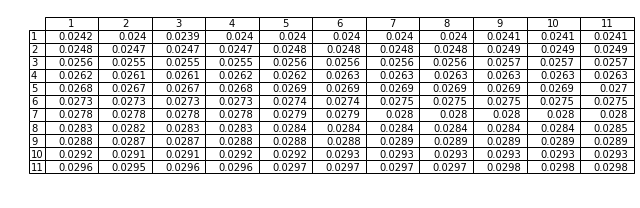

In [305]:
ColLable = [i for i in range(1, 12)]
RowLable = [i for i in range(1, 12)]
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('off')
ax.axis('tight')

ax.table(cellText=NMAE_table, rowLabels= RowLable, colLabels = ColLable, loc='center')
fig.tight_layout()
plt.show()

In [195]:
xtrain, ytrain = create_data(X_train, Y_train, 1, 1)
xtest, ytest = create_data(X_test, Y_test, 1, 1)
Linear = LinearRegression()
Linear.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [196]:
pred = Linear.predict(xtest)

In [197]:
# print(CalculateNMAE(pred[:,1], ytest['WritesAvg1']))
print(CalculateNMAE(pred[:,0], ytest['WritesAvg0']))
print(CalculateNMAE(pred, ytest))

0.024153412894430955
WritesAvg0    0.024153
dtype: float64


In [110]:
for i in range(3):
#     target_copy = data_Y.copy()
    del_list = []
    for j in range(3 + i):
        del_list.append(j)
    for k in range(3 -1 - i):
        del_list.append(10 - k -1)
    print(del_list)

[0, 1, 2, 9, 8]
[0, 1, 2, 3, 9]
[0, 1, 2, 3, 4]


In [65]:
RNN_NMAE_table = []
for h in range(1, 12):
    temp_list = []
    print(RNN_NMAE_table)
    for l in range(1, 12):
        RNN_xtrain, RNN_ytrain = create_data(X_train, Y_train, l, h)
        RNN_xtest, RNN_ytest = create_data(X_test, Y_test, l, h)
        RNNmodel = BuildRNN_Multi_Step_LSTM(RNN_xtrain, RNN_ytrain, l, h, 16)
        RNNtest = RNN_reshape(RNN_xtest, l, 16)
        RNNpred = RNNmodel.predict(RNNtest)
        temp_list.append(round(CalculateNMAE(RNNpred, RNN_ytest)[0], 4))
    RNN_NMAE_table.append(temp_list)

[]
Epoch 1/50
13553/13553 [==============================] - 14s 1ms/step - loss: 12216.5020
Epoch 2/50
13553/13553 [==============================] - 1s 62us/step - loss: 12151.9588
Epoch 3/50
13553/13553 [==============================] - 1s 61us/step - loss: 11851.1795
Epoch 4/50
13553/13553 [==============================] - 1s 62us/step - loss: 10423.5830
Epoch 5/50
13553/13553 [==============================] - 1s 61us/step - loss: 6905.1543
Epoch 6/50
13553/13553 [==============================] - 1s 61us/step - loss: 3485.5468
Epoch 7/50
13553/13553 [==============================] - 1s 61us/step - loss: 2382.4755
Epoch 8/50
13553/13553 [==============================] - 1s 60us/step - loss: 2133.3476
Epoch 9/50
13553/13553 [==============================] - 1s 59us/step - loss: 1916.6729
Epoch 10/50
13553/13553 [==============================] - 1s 62us/step - loss: 1732.7036
Epoch 11/50
13553/13553 [==============================] - 1s 62us/step - loss: 1571.5264
Epoch 12/50


13552/13552 [==============================] - 1s 109us/step - loss: 19.8519
Epoch 43/50
13552/13552 [==============================] - 2s 112us/step - loss: 19.1784
Epoch 44/50
13552/13552 [==============================] - 2s 111us/step - loss: 18.6616
Epoch 45/50
13552/13552 [==============================] - 1s 110us/step - loss: 17.9772
Epoch 46/50
13552/13552 [==============================] - 1s 110us/step - loss: 17.4399
Epoch 47/50
13552/13552 [==============================] - 1s 110us/step - loss: 17.6572
Epoch 48/50
13552/13552 [==============================] - 1s 109us/step - loss: 17.0682
Epoch 49/50
13552/13552 [==============================] - 1s 110us/step - loss: 17.1842
Epoch 50/50
13552/13552 [==============================] - 1s 109us/step - loss: 16.9677
Epoch 1/50
13551/13551 [==============================] - 16s 1ms/step - loss: 12169.8382
Epoch 2/50
13551/13551 [==============================] - 2s 156us/step - loss: 10984.5543
Epoch 3/50
13551/13551 [======

Epoch 34/50
13550/13550 [==============================] - 3s 200us/step - loss: 15.5532
Epoch 35/50
13550/13550 [==============================] - 3s 201us/step - loss: 15.3595
Epoch 36/50
13550/13550 [==============================] - 3s 200us/step - loss: 15.0691
Epoch 37/50
13550/13550 [==============================] - 3s 205us/step - loss: 14.8335
Epoch 38/50
13550/13550 [==============================] - 3s 201us/step - loss: 14.7424
Epoch 39/50
13550/13550 [==============================] - 3s 203us/step - loss: 14.6268
Epoch 40/50
13550/13550 [==============================] - 3s 200us/step - loss: 14.6089
Epoch 41/50
13550/13550 [==============================] - 3s 202us/step - loss: 14.6694
Epoch 42/50
13550/13550 [==============================] - 3s 201us/step - loss: 14.6156
Epoch 43/50
13550/13550 [==============================] - 3s 202us/step - loss: 14.5328
Epoch 44/50
13550/13550 [==============================] - 3s 207us/step - loss: 14.9080
Epoch 45/50
13550/135

13548/13548 [==============================] - 4s 295us/step - loss: 15.1210
Epoch 27/50
13548/13548 [==============================] - 4s 296us/step - loss: 15.1890
Epoch 28/50
13548/13548 [==============================] - 4s 297us/step - loss: 14.9179
Epoch 29/50
13548/13548 [==============================] - 4s 294us/step - loss: 14.5561
Epoch 30/50
13548/13548 [==============================] - 4s 298us/step - loss: 14.4876
Epoch 31/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.6368
Epoch 32/50
13548/13548 [==============================] - 4s 298us/step - loss: 15.2450
Epoch 33/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.8677
Epoch 34/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.3411
Epoch 35/50
13548/13548 [==============================] - 4s 298us/step - loss: 14.1401
Epoch 36/50
13548/13548 [==============================] - 4s 303us/step - loss: 14.1171
Epoch 37/50
13548/13548 [========

13546/13546 [==============================] - 5s 402us/step - loss: 15.8365
Epoch 19/50
13546/13546 [==============================] - 5s 399us/step - loss: 15.0982
Epoch 20/50
13546/13546 [==============================] - 5s 400us/step - loss: 14.8309
Epoch 21/50
13546/13546 [==============================] - 5s 400us/step - loss: 14.7923
Epoch 22/50
13546/13546 [==============================] - 5s 399us/step - loss: 14.8035
Epoch 23/50
13546/13546 [==============================] - 5s 400us/step - loss: 14.5372
Epoch 24/50
13546/13546 [==============================] - 5s 403us/step - loss: 15.4404
Epoch 25/50
13546/13546 [==============================] - 5s 403us/step - loss: 14.7703
Epoch 26/50
13546/13546 [==============================] - 5s 401us/step - loss: 14.4977
Epoch 27/50
13546/13546 [==============================] - 5s 398us/step - loss: 14.2264
Epoch 28/50
13546/13546 [==============================] - 5s 399us/step - loss: 13.9047
Epoch 29/50
13546/13546 [========

13544/13544 [==============================] - 7s 497us/step - loss: 16.3741
Epoch 11/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.9293
Epoch 12/50
13544/13544 [==============================] - 7s 497us/step - loss: 16.4933
Epoch 13/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.5518
Epoch 14/50
13544/13544 [==============================] - 7s 499us/step - loss: 15.1362
Epoch 15/50
13544/13544 [==============================] - 7s 501us/step - loss: 15.1136
Epoch 16/50
13544/13544 [==============================] - 7s 499us/step - loss: 15.1509
Epoch 17/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.3933
Epoch 18/50
13544/13544 [==============================] - 7s 499us/step - loss: 14.7501
Epoch 19/50
13544/13544 [==============================] - 7s 499us/step - loss: 14.1874
Epoch 20/50
13544/13544 [==============================] - 7s 500us/step - loss: 14.5555
Epoch 21/50
13544/13544 [========

13552/13552 [==============================] - 22s 2ms/step - loss: 12221.6155
Epoch 2/50
13552/13552 [==============================] - 1s 62us/step - loss: 12168.0690
Epoch 3/50
13552/13552 [==============================] - 1s 63us/step - loss: 11875.5096
Epoch 4/50
13552/13552 [==============================] - 1s 62us/step - loss: 10565.7966
Epoch 5/50
13552/13552 [==============================] - 1s 62us/step - loss: 7962.5831
Epoch 6/50
13552/13552 [==============================] - 1s 62us/step - loss: 5090.9134
Epoch 7/50
13552/13552 [==============================] - 1s 62us/step - loss: 3117.2532
Epoch 8/50
13552/13552 [==============================] - 1s 63us/step - loss: 2107.2099
Epoch 9/50
13552/13552 [==============================] - 1s 61us/step - loss: 1885.2366
Epoch 10/50
13552/13552 [==============================] - 1s 62us/step - loss: 1694.8306
Epoch 11/50
13552/13552 [==============================] - 1s 62us/step - loss: 1548.5759
Epoch 12/50
13552/13552 [=

13551/13551 [==============================] - 1s 109us/step - loss: 20.1324
Epoch 43/50
13551/13551 [==============================] - 2s 111us/step - loss: 19.5338
Epoch 44/50
13551/13551 [==============================] - 1s 110us/step - loss: 19.0798
Epoch 45/50
13551/13551 [==============================] - 2s 111us/step - loss: 18.7394
Epoch 46/50
13551/13551 [==============================] - 1s 110us/step - loss: 18.5955
Epoch 47/50
13551/13551 [==============================] - 1s 111us/step - loss: 18.2696
Epoch 48/50
13551/13551 [==============================] - 1s 109us/step - loss: 17.9817
Epoch 49/50
13551/13551 [==============================] - 1s 110us/step - loss: 17.8168
Epoch 50/50
13551/13551 [==============================] - 1s 110us/step - loss: 17.9313
(13550, 2)
(5806, 2)
Epoch 1/50
13550/13550 [==============================] - 24s 2ms/step - loss: 12193.2929
Epoch 2/50
13550/13550 [==============================] - 2s 158us/step - loss: 11621.3123
Epoch 3/5

13549/13549 [==============================] - 3s 209us/step - loss: 16.8602
Epoch 34/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.5506
Epoch 35/50
13549/13549 [==============================] - 4s 269us/step - loss: 16.2822
Epoch 36/50
13549/13549 [==============================] - 3s 211us/step - loss: 16.1540
Epoch 37/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.0082
Epoch 38/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.0601
Epoch 39/50
13549/13549 [==============================] - 3s 210us/step - loss: 15.9468
Epoch 40/50
13549/13549 [==============================] - 3s 209us/step - loss: 16.2619
Epoch 41/50
13549/13549 [==============================] - 3s 209us/step - loss: 16.2746
Epoch 42/50
13549/13549 [==============================] - 3s 211us/step - loss: 16.1168
Epoch 43/50
13549/13549 [==============================] - 3s 216us/step - loss: 15.8806
Epoch 44/50
13549/13549 [========

13547/13547 [==============================] - 4s 311us/step - loss: 16.2516
Epoch 25/50
13547/13547 [==============================] - 4s 311us/step - loss: 16.0550
Epoch 26/50
13547/13547 [==============================] - 4s 309us/step - loss: 16.4285
Epoch 27/50
13547/13547 [==============================] - 4s 312us/step - loss: 16.8181
Epoch 28/50
13547/13547 [==============================] - 4s 311us/step - loss: 16.7646
Epoch 29/50
13547/13547 [==============================] - 4s 310us/step - loss: 16.0582
Epoch 30/50
13547/13547 [==============================] - 4s 310us/step - loss: 15.5887
Epoch 31/50
13547/13547 [==============================] - 4s 316us/step - loss: 16.2528
Epoch 32/50
13547/13547 [==============================] - 4s 310us/step - loss: 15.9085
Epoch 33/50
13547/13547 [==============================] - 4s 312us/step - loss: 15.5313
Epoch 34/50
13547/13547 [==============================] - 4s 310us/step - loss: 15.6387
Epoch 35/50
13547/13547 [========

13545/13545 [==============================] - 6s 408us/step - loss: 17.9700
Epoch 16/50
13545/13545 [==============================] - 5s 406us/step - loss: 17.2342
Epoch 17/50
13545/13545 [==============================] - 5s 405us/step - loss: 17.6470
Epoch 18/50
13545/13545 [==============================] - 6s 406us/step - loss: 19.2141
Epoch 19/50
13545/13545 [==============================] - 5s 406us/step - loss: 18.1833
Epoch 20/50
13545/13545 [==============================] - 6s 409us/step - loss: 17.3017
Epoch 21/50
13545/13545 [==============================] - 6s 413us/step - loss: 16.4112
Epoch 22/50
13545/13545 [==============================] - 6s 407us/step - loss: 16.3915
Epoch 23/50
13545/13545 [==============================] - 6s 407us/step - loss: 17.0534
Epoch 24/50
13545/13545 [==============================] - 6s 409us/step - loss: 17.1302
Epoch 25/50
13545/13545 [==============================] - 6s 407us/step - loss: 17.4189
Epoch 26/50
13545/13545 [========

13543/13543 [==============================] - 7s 509us/step - loss: 32.4388
Epoch 7/50
13543/13543 [==============================] - 7s 501us/step - loss: 25.7321
Epoch 8/50
13543/13543 [==============================] - 7s 498us/step - loss: 22.6960
Epoch 9/50
13543/13543 [==============================] - 7s 501us/step - loss: 21.3155
Epoch 10/50
13543/13543 [==============================] - 7s 503us/step - loss: 20.2833
Epoch 11/50
13543/13543 [==============================] - 7s 506us/step - loss: 19.5309
Epoch 12/50
13543/13543 [==============================] - 7s 504us/step - loss: 18.6837
Epoch 13/50
13543/13543 [==============================] - 7s 502us/step - loss: 18.2361
Epoch 14/50
13543/13543 [==============================] - 7s 502us/step - loss: 17.4854
Epoch 15/50
13543/13543 [==============================] - 7s 505us/step - loss: 17.0511
Epoch 16/50
13543/13543 [==============================] - 7s 503us/step - loss: 17.1900
Epoch 17/50
13543/13543 [===========

13542/13542 [==============================] - 8s 554us/step - loss: 15.9455
Epoch 49/50
13542/13542 [==============================] - 8s 555us/step - loss: 16.1921
Epoch 50/50
13542/13542 [==============================] - 8s 562us/step - loss: 15.4244
[[0.042, 0.0275, 0.025, 0.0263, 0.0248, 0.024, 0.0253, 0.0265, 0.0251, 0.0278, 0.027], [0.0479, 0.0266, 0.0254, 0.0266, 0.0255, 0.0247, 0.0262, 0.0263, 0.0272, 0.0264, 0.0258]]
(13551, 2)
(13551, 3)
(5807, 2)
(5807, 3)
Epoch 1/50
13551/13551 [==============================] - 28s 2ms/step - loss: 12222.7327
Epoch 2/50
13551/13551 [==============================] - 1s 65us/step - loss: 12179.7466
Epoch 3/50
13551/13551 [==============================] - 1s 64us/step - loss: 11942.2822
Epoch 4/50
13551/13551 [==============================] - 1s 63us/step - loss: 10804.0391
Epoch 5/50
13551/13551 [==============================] - 1s 64us/step - loss: 8405.1186
Epoch 6/50
13551/13551 [==============================] - 1s 65us/step - loss

13550/13550 [==============================] - 2s 115us/step - loss: 27.4281
Epoch 37/50
13550/13550 [==============================] - 2s 117us/step - loss: 26.1209
Epoch 38/50
13550/13550 [==============================] - 2s 113us/step - loss: 24.9505
Epoch 39/50
13550/13550 [==============================] - 2s 121us/step - loss: 24.1111
Epoch 40/50
13550/13550 [==============================] - 2s 113us/step - loss: 23.4603
Epoch 41/50
13550/13550 [==============================] - 2s 114us/step - loss: 22.8363
Epoch 42/50
13550/13550 [==============================] - 2s 113us/step - loss: 22.4454
Epoch 43/50
13550/13550 [==============================] - 2s 114us/step - loss: 22.0075
Epoch 44/50
13550/13550 [==============================] - 2s 113us/step - loss: 21.6021
Epoch 45/50
13550/13550 [==============================] - 2s 114us/step - loss: 21.2235
Epoch 46/50
13550/13550 [==============================] - 5s 346us/step - loss: 20.8254
Epoch 47/50
13550/13550 [========

13548/13548 [==============================] - 3s 208us/step - loss: 20.2114
Epoch 28/50
13548/13548 [==============================] - 3s 208us/step - loss: 19.7850
Epoch 29/50
13548/13548 [==============================] - 3s 207us/step - loss: 19.5348
Epoch 30/50
13548/13548 [==============================] - 3s 208us/step - loss: 19.1598
Epoch 31/50
13548/13548 [==============================] - 3s 210us/step - loss: 18.9781
Epoch 32/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.5918
Epoch 33/50
13548/13548 [==============================] - 3s 209us/step - loss: 18.3898
Epoch 34/50
13548/13548 [==============================] - 3s 209us/step - loss: 18.3553
Epoch 35/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.2817
Epoch 36/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.3660
Epoch 37/50
13548/13548 [==============================] - 3s 207us/step - loss: 18.3508
Epoch 38/50
13548/13548 [========

13546/13546 [==============================] - 4s 312us/step - loss: 23.5059
Epoch 19/50
13546/13546 [==============================] - 4s 310us/step - loss: 22.5783
Epoch 20/50
13546/13546 [==============================] - 4s 308us/step - loss: 21.8825
Epoch 21/50
13546/13546 [==============================] - 4s 306us/step - loss: 21.4220
Epoch 22/50
13546/13546 [==============================] - 4s 306us/step - loss: 21.2258
Epoch 23/50
13546/13546 [==============================] - 4s 307us/step - loss: 20.5141
Epoch 24/50
13546/13546 [==============================] - 4s 307us/step - loss: 19.8959
Epoch 25/50
13546/13546 [==============================] - 4s 306us/step - loss: 20.2716
Epoch 26/50
13546/13546 [==============================] - 4s 307us/step - loss: 19.3948
Epoch 27/50
13546/13546 [==============================] - 4s 306us/step - loss: 18.7871
Epoch 28/50
13546/13546 [==============================] - 4s 308us/step - loss: 18.5399
Epoch 29/50
13546/13546 [========

13544/13544 [==============================] - 5s 400us/step - loss: 25.6537
Epoch 10/50
13544/13544 [==============================] - 5s 405us/step - loss: 24.2475
Epoch 11/50
13544/13544 [==============================] - 5s 404us/step - loss: 23.8081
Epoch 12/50
13544/13544 [==============================] - 5s 403us/step - loss: 22.5240
Epoch 13/50
13544/13544 [==============================] - 5s 406us/step - loss: 21.7817
Epoch 14/50
13544/13544 [==============================] - 5s 404us/step - loss: 21.3113
Epoch 15/50
13544/13544 [==============================] - 5s 403us/step - loss: 21.3398
Epoch 16/50
13544/13544 [==============================] - 5s 402us/step - loss: 20.3683
Epoch 17/50
13544/13544 [==============================] - 5s 402us/step - loss: 20.4849
Epoch 18/50
13544/13544 [==============================] - 5s 403us/step - loss: 19.9367
Epoch 19/50
13544/13544 [==============================] - 5s 405us/step - loss: 19.5790
Epoch 20/50
13544/13544 [========

13543/13543 [==============================] - 6s 455us/step - loss: 16.9648
(13542, 2)
(13542, 3)
(5798, 2)
(5798, 3)
Epoch 1/50
13542/13542 [==============================] - 40s 3ms/step - loss: 11715.6350
Epoch 2/50
13542/13542 [==============================] - 7s 503us/step - loss: 5692.8025
Epoch 3/50
13542/13542 [==============================] - 7s 504us/step - loss: 872.7836
Epoch 4/50
13542/13542 [==============================] - 7s 510us/step - loss: 183.8116
Epoch 5/50
13542/13542 [==============================] - 7s 512us/step - loss: 69.7983
Epoch 6/50
13542/13542 [==============================] - 7s 506us/step - loss: 39.4318
Epoch 7/50
13542/13542 [==============================] - 7s 503us/step - loss: 30.2074
Epoch 8/50
13542/13542 [==============================] - 7s 502us/step - loss: 27.3646
Epoch 9/50
13542/13542 [==============================] - 7s 505us/step - loss: 25.3196
Epoch 10/50
13542/13542 [==============================] - 7s 506us/step - loss: 23

KeyboardInterrupt: 

In [ ]:
RNN_xtrain, RNN_ytrain = create_data(X_train, Y_train, 3, 2)
RNN_xtest, RNN_ytest = create_data(X_test, Y_test, 3, 2)
RNNmodel = BuildRNN_Multi_Step_LSTM(RNN_xtrain, RNN_ytrain, 3, 2, 16)

(13550, 2)
(5806, 2)
Epoch 1/50
13550/13550 [==============================] - 30s 2ms/step - loss: 1660.6970
Epoch 2/50
13550/13550 [==============================] - 23s 2ms/step - loss: 22.1063
Epoch 3/50
 9600/13550 [====================>.........] - ETA: 6s - loss: 19.3010

In [34]:
RNNtest = RNN_reshape(RNN_xtest, 3, 16)

In [36]:
RNNpred = RNNmodel.predict(RNNtest)

In [37]:
print(CalculateNMAE(RNNpred, RNN_ytest))

WritesAvg0    0.026008
WritesAvg1    0.026008
dtype: float64
